### Data Description

The dataset consists of customer information for a customer churn prediction problem, containing the following columns:

- **CustomerID**: Unique identifier for each customer.
- **Name**: Name of the customer.
- **Age**: Age of the customer.
- **Gender**: Gender of the customer (Male or Female).
- **Location**: Location where the customer is based, with options including Houston, Los Angeles, Miami, Chicago, and New York.
- **Subscription_Length_Months**: The number of months the customer has been subscribed.
- **Monthly_Bill**: Monthly bill amount for the customer.
- **Total_Usage_GB**: Total usage in gigabytes.
- **Churn**: A binary indicator (1 or 0) representing whether the customer has churned (1) or not (0).


In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
import optuna

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc ,confusion_matrix ,roc_auc_score

In [2]:
df = pd.read_excel('../datasets/customer_churn_large_dataset.xlsx')
df.head(10)

,CustomerID,Name,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,1,Customer_1,63,Male,Los Angeles,17,73.36,236,0
1,2,Customer_2,62,Female,New York,1,48.76,172,0
2,3,Customer_3,24,Female,Los Angeles,5,85.47,460,0
3,4,Customer_4,36,Female,Miami,3,97.94,297,1
4,5,Customer_5,46,Female,Miami,19,58.14,266,0
5,6,Customer_6,67,Male,New York,15,82.65,456,1
6,7,Customer_7,30,Female,Chicago,3,73.79,269,0
7,8,Customer_8,67,Female,Miami,1,97.70,396,1
8,9,Customer_9,20,Female,Miami,10,42.45,150,1
9,10,Customer_10,53,Female,Los Angeles,12,64.49,383,1


In [3]:
df.tail(10)

,CustomerID,Name,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
99990,99991,Customer_99991,62,Male,Chicago,9,36.34,432,0
99991,99992,Customer_99992,55,Female,Miami,14,73.87,324,1
99992,99993,Customer_99993,44,Male,New York,18,45.87,229,0
99993,99994,Customer_99994,20,Female,Houston,15,84.72,312,1
99994,99995,Customer_99995,47,Female,Houston,8,34.58,200,0
99995,99996,Customer_99996,33,Male,Houston,23,55.13,226,1
99996,99997,Customer_99997,62,Female,New York,19,61.65,351,0
99997,99998,Customer_99998,64,Male,Chicago,17,96.11,251,1
99998,99999,Customer_99999,51,Female,New York,20,49.25,434,1
99999,100000,Customer_100000,27,Female,Los Angeles,19,76.57,173,1


#### Fist glance observation of data

#### The Customer ID and seems to be of no use as its just unique id so we can drop them


In [4]:
## Before making any changes to data making a copy of it
df_copy = df.copy()

In [5]:
#drop customerID and name attributes from dataframe
df_copy.drop(['CustomerID', 'Name'], axis = 1, inplace = True)

## Exploratory Data Analysis (EDA)

In [6]:
df_copy.shape

(100000, 7)

In [7]:
df_copy.columns

Index(['Age', 'Gender', 'Location', 'Subscription_Length_Months',
       'Monthly_Bill', 'Total_Usage_GB', 'Churn'],
      dtype='object')

In [8]:
# checking the information about a DataFrame 
df_copy.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Age                         100000 non-null  int64  
 1   Gender                      100000 non-null  object 
 2   Location                    100000 non-null  object 
 3   Subscription_Length_Months  100000 non-null  int64  
 4   Monthly_Bill                100000 non-null  float64
 5   Total_Usage_GB              100000 non-null  int64  
 6   Churn                       100000 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 5.3+ MB


#### ALl features have correct number of data

In [9]:
## Check for null values
df_copy.isna().sum()


Age                           0
Gender                        0
Location                      0
Subscription_Length_Months    0
Monthly_Bill                  0
Total_Usage_GB                0
Churn                         0
dtype: int64

#### No null values found

In [10]:
## checking for duplicated
df_copy.duplicated().sum()

0

#### No duplicate values found

In [11]:
# Statistical summary of numerical variables

df_copy.describe()

,Age,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,44.027020,12.490100,65.053197,274.393650,0.497790
std,15.280283,6.926461,20.230696,130.463063,0.499998
min,18.000000,1.000000,30.000000,50.000000,0.000000
25%,31.000000,6.000000,47.540000,161.000000,0.000000
50%,44.000000,12.000000,65.010000,274.000000,0.000000
75%,57.000000,19.000000,82.640000,387.000000,1.000000
max,70.000000,24.000000,100.000000,500.000000,1.000000


### Age

- The average age of the customers is approximately 44 years.
- The ages of the people vary widely, ranging from 18 to 70 years.
- The majority of customers fall within the age range of 31 to 57 years.

### Subscription_Length_Months

- On average, customers have a subscription length of around 12.5 months.
- Subscription lengths vary between 1 and 24 months.
- The majority of customers have subscription lengths ranging from 6 to 19 months.
- The standard deviation is approximately 6.9 months, indicating some variation in subscription lengths.

### Monthly_Bill

- Customers pay an average monthly bill of roughly $65.
- Monthly bills range from $30 (minimum) to $100 (maximum).
- The majority of customers pay between approximately $47.50 to $82.64 per month.
- Monthly bill amounts have a standard deviation of about $20.23, showing some variability.

### Total_Usage_GB

- The average total usage of customers is about 274.4 GB.
- Total usage varies between 50 GB (minimum) and 500 GB (maximum).
- Most customers have total usage between 161 GB and 387 GB.
- Total usage has a standard deviation of approximately 130.46 GB, indicating a significant range.

### Churn

- About half of the customers have churned (Churn value = 1), while the other half haven't (Churn value = 0).
- This is represented by a mean churn rate of approximately 0.5.
- Churn values are binary (0 or 1), indicating whether a customer has churned or not.
- The churn rate is evenly distributed due to a mean close to 0.5.


In [12]:
## Checking unique value of categorical columns
categorical_columns = df_copy.select_dtypes(include=['object']).columns
# Exclude the "Name" column from the list of categorical columns
categorical_columns = [col for col in categorical_columns if col != "Name"]

for column in categorical_columns:
    unique_values = df_copy[column].unique()
    print(f"Unique values in column '{column}':")
    for value in unique_values:
        print(value)
    print("\n")

Unique values in column 'Gender':
Male
Female


Unique values in column 'Location':
Los Angeles
New York
Miami
Chicago
Houston




In [13]:

# Statistical summary of categorical variables
df_copy.describe(include=['object'])



,Gender,Location
count,100000,100000
unique,2,5
top,Female,Houston
freq,50216,20157


In [14]:
# Finding count of each value in categorical column
categorical_columns = df.select_dtypes(include=['object']).columns

# Exclude the "Name" column from the list of categorical columns
categorical_columns = [col for col in categorical_columns if col != "Name"]

for column in categorical_columns:
    value_counts = df[column].value_counts()
    print(f"Value counts for column '{column}':")
    print(value_counts)
    print("\n")

Value counts for column 'Gender':
Gender
Female    50216
Male      49784
Name: count, dtype: int64


Value counts for column 'Location':
Location
Houston        20157
Los Angeles    20041
Miami          20031
Chicago        19958
New York       19813
Name: count, dtype: int64





### Gender

- The dataset includes information about two unique genders.
- The most common gender is "Female," which appears 50,216 times.
- The frequency of females in the dataset is greater than that Male.

### Location

- The dataset contains information about five unique locations[Houston, Los Angeles, Miami, Chicago, New York].
- The most frequent location is "Houston," occurring 20,157 times.



In [15]:
# Checking correlation between numerical variables

numerical_columns = df_copy.select_dtypes(include=['number'])  

if not numerical_columns.empty:
    correlation_matrix = numerical_columns.corr()  


    print("Correlation Matrix between Numerical Variables:")
    print(correlation_matrix)
else:
    print("No numerical columns found in the DataFrame.")

Correlation Matrix between Numerical Variables:
                                 Age  Subscription_Length_Months  \
Age                         1.000000                    0.003382   
Subscription_Length_Months  0.003382                    1.000000   
Monthly_Bill                0.001110                   -0.005294   
Total_Usage_GB              0.001927                   -0.002203   
Churn                       0.001559                    0.002328   

                            Monthly_Bill  Total_Usage_GB     Churn  
Age                             0.001110        0.001927  0.001559  
Subscription_Length_Months     -0.005294       -0.002203  0.002328  
Monthly_Bill                    1.000000        0.003187 -0.000211  
Total_Usage_GB                  0.003187        1.000000 -0.002842  
Churn                          -0.000211       -0.002842  1.000000  


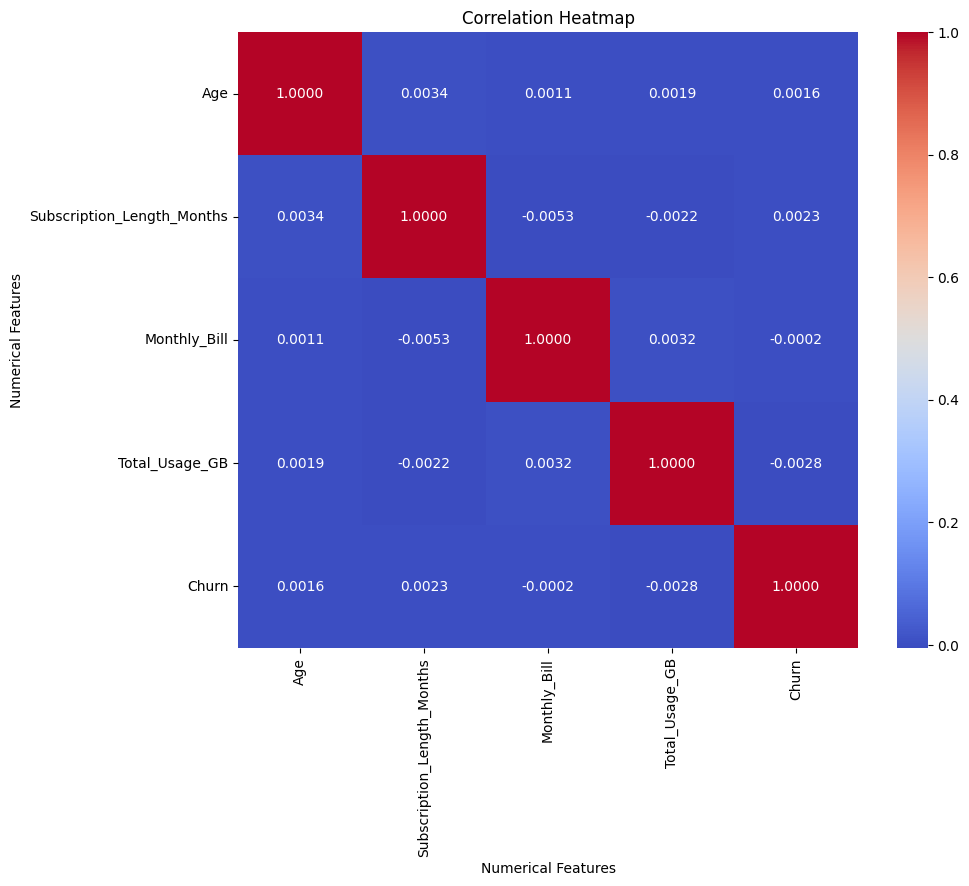

In [16]:
# Creating a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".4f")

# Adding labels and title
plt.xlabel("Numerical Features")
plt.ylabel("Numerical Features")
plt.title("Correlation Heatmap")

# Show the heatmap
plt.show()


**Age vs. Other Variables:**

- Age also has very weak correlations with other variables, all of which are close to zero. This indicates that age is not strongly correlated with the other numerical features.

**Subscription_Length_Months vs. Other Variables:**

- Subscription_Length_Months has a very weak positive correlation with itself (perfect correlation with itself, as expected), but its correlations with other variables are also very weak and close to zero. There is no strong correlation observed.

**Monthly_Bill vs. Other Variables:**

- Monthly_Bill has very weak correlations with all other variables. It is not strongly correlated with age, subscription length, total usage, or churn.

**Total_Usage_GB vs. Other Variables:**

- Total_Usage_GB has very weak correlations with all other variables. There is no strong correlation observed with age, subscription length, monthly bill, or churn.

**Churn vs. Other Variables:**
``
- Churn, being a binary variable (0 or 1), has very weak correlations with all other numerical variables. There is no strong linear correlation between churn and the other numerical features.



#### No multicollinearity in our dataset, so all the remaining columns of our dataset are equally important for predicting our class variable



In [17]:
# separating the numerical and categorical columns

numerical_columns = df_copy.select_dtypes(include=['float64', 'int64']).columns

# Exclude binary variables from the list
binary_columns = [var for var in numerical_columns if df_copy[var].nunique() == 2]

# Exclude binary variables from the continuous variables
numerical_columns = [var for var in numerical_columns if var not in binary_columns]
print(numerical_columns)

# categorical columns
categorical_columns = df_copy.select_dtypes(exclude='number').columns
categorical_columns = list(categorical_columns)
print(categorical_columns)




['Age', 'Subscription_Length_Months', 'Monthly_Bill', 'Total_Usage_GB']
['Gender', 'Location']


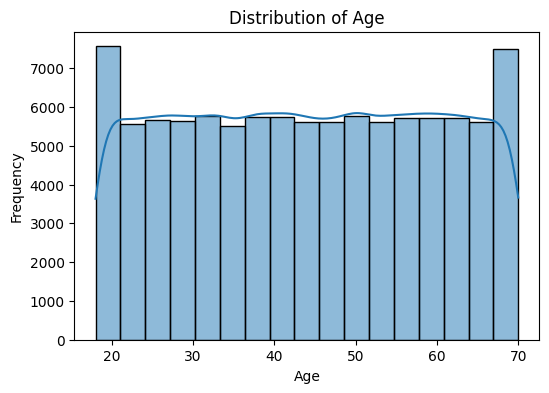

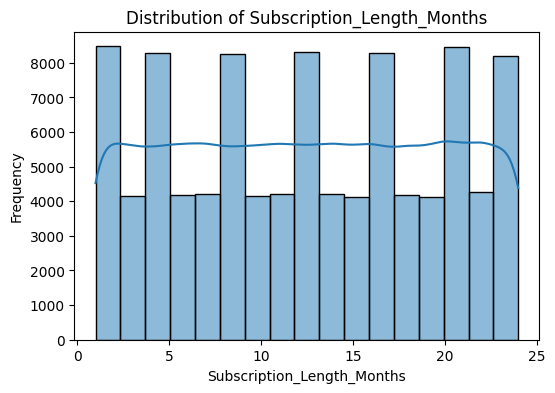

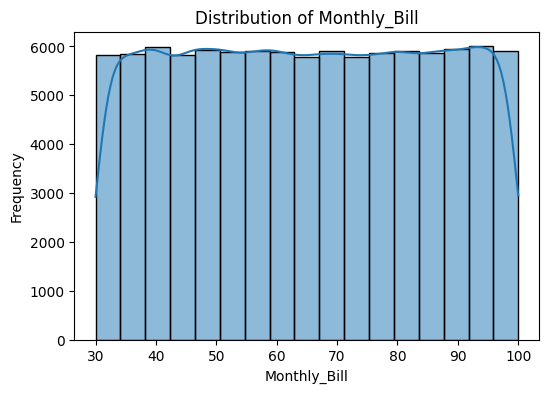

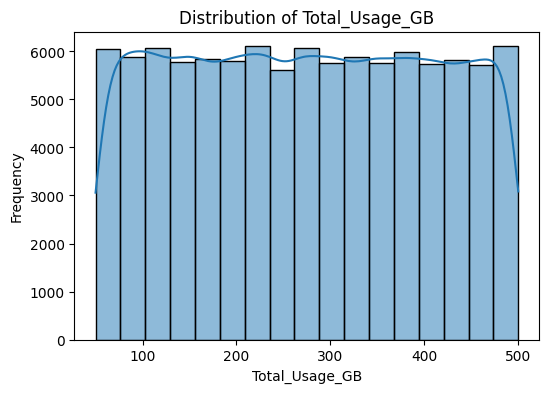

In [18]:
# Plot the distribution of each continuous variable
for var in numerical_columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df_copy, x=var, bins=17, kde=True)
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {var}')
    plt.show()

In [19]:
# check skewness of all continuous variables
df_copy[numerical_columns].skew()


Age                          -0.002689
Subscription_Length_Months   -0.001655
Monthly_Bill                 -0.000326
Total_Usage_GB                0.007113
dtype: float64

**All variables are approx normally distributed.**

**We have many unique values in each column, but they're all almost balanced.**

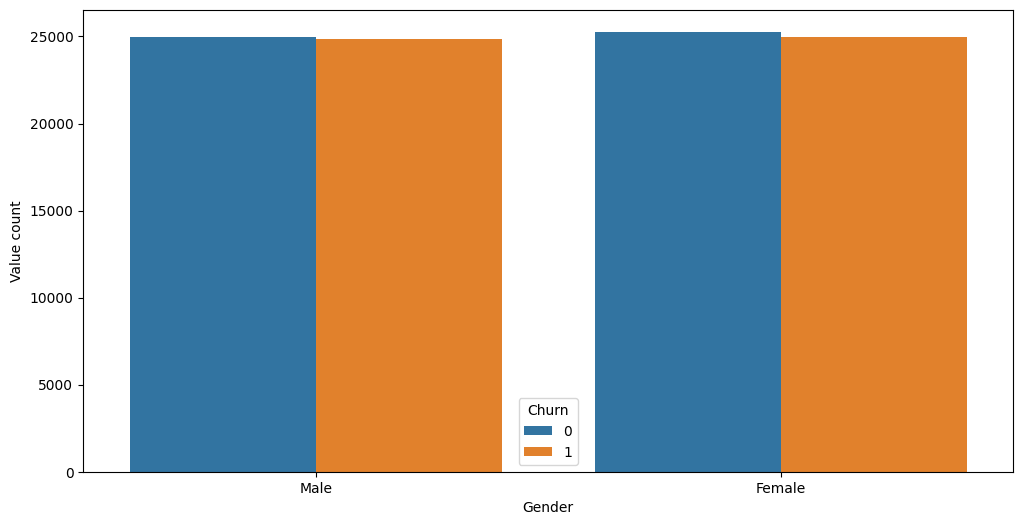

In [20]:
# count plots
fig, ax = plt.subplots(figsize=(12,6)  , dpi=100)
sns.countplot(x='Gender', hue="Churn", data=df_copy)
ax.set_xlabel('Gender')
ax.set_ylabel('Value count')
plt.show()

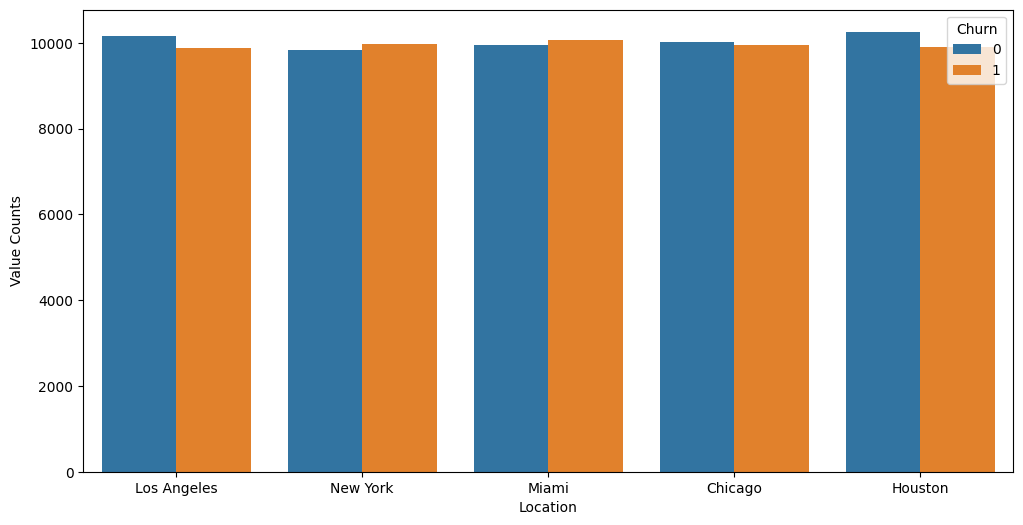

In [21]:
fig, ax = plt.subplots(figsize=(12,6), dpi=100)

sns.countplot(x='Location', hue="Churn", data=df_copy)

ax.set_xlabel('Location')
ax.set_ylabel('Value Counts')

plt.show()


### checking Outliers 

It is important to find and remove unusual or extreme data points, also known as outliers. Outliers can affect the model's understanding of the data and lead to wrong predictions. 


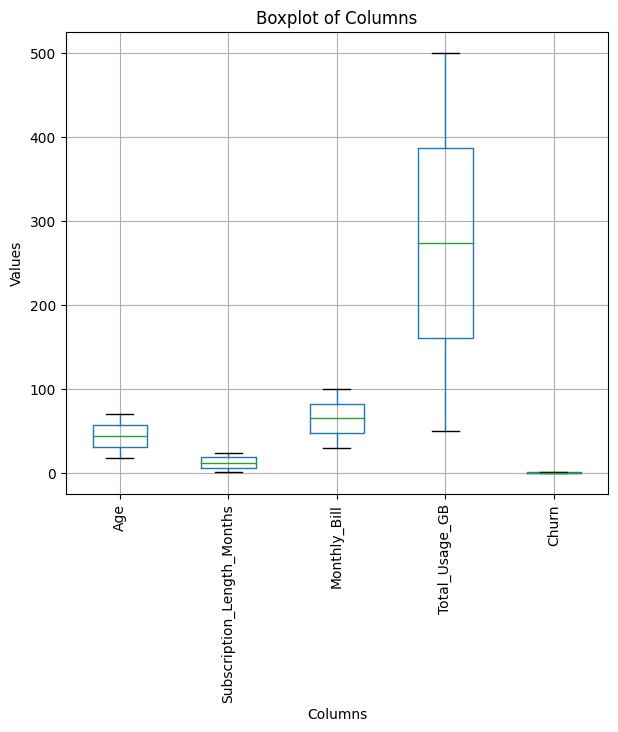

In [22]:


# Adjust figure size based on the number of columns
num_columns = len(df_copy.columns)
fig, ax = plt.subplots(figsize=(10, 6))
if num_columns > 16:
    fig.set_size_inches(10, num_columns * 0.6)
else:
    fig.set_size_inches(num_columns, 6)

# Create a boxplot for each column
df_copy.boxplot(ax=ax)

# Set the title and labels
plt.title("Boxplot of Columns")
plt.xlabel("Columns")
plt.ylabel("Values")

# Rotate the x-axis labels for better readability (optional)
plt.xticks(rotation=90)

# Show the plot
plt.show()



**No outliers found in any columns**


### Feature Encoding
**Converting the categorical columns to numerical columns. I have done one hot encoding as there are less categorical columns**

In [23]:
df_copy = pd.get_dummies(df_copy, columns=['Gender', 'Location'], drop_first=True)
df_copy = df_copy * 1

In [24]:
df_copy.head()

,Age,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn,Gender_Male,Location_Houston,Location_Los Angeles,Location_Miami,Location_New York
0,63,17,73.36,236,0,1,0,1,0,0
1,62,1,48.76,172,0,0,0,0,0,1
2,24,5,85.47,460,0,0,0,1,0,0
3,36,3,97.94,297,1,0,0,0,1,0
4,46,19,58.14,266,0,0,0,0,1,0


In [25]:

df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Age                         100000 non-null  int64  
 1   Subscription_Length_Months  100000 non-null  int64  
 2   Monthly_Bill                100000 non-null  float64
 3   Total_Usage_GB              100000 non-null  int64  
 4   Churn                       100000 non-null  int64  
 5   Gender_Male                 100000 non-null  int32  
 6   Location_Houston            100000 non-null  int32  
 7   Location_Los Angeles        100000 non-null  int32  
 8   Location_Miami              100000 non-null  int32  
 9   Location_New York           100000 non-null  int32  
dtypes: float64(1), int32(5), int64(4)
memory usage: 5.7 MB


### Dividing data into train and test set

In [26]:
X = df_copy.drop("Churn",axis=1)
y = df_copy['Churn']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

In [29]:
X_train.shape, y_train.shape

((70000, 9), (70000,))

In [30]:
X_test.shape, y_test.shape

((30000, 9), (30000,))

**Dividing the dataset into train and test with 70:30 ratio**

## Feature Scaling

- Feature scaling will make sure that all the features are on same scale.
- Feature scaling is important because it ensures that no single feature dominates the learning process. This is because many machine learning algorithms use distance-based calculations, and if features are on different scales, those with larger values could disproportionately influence the results. 
- Feature scaling also helps to improve the convergence of gradient-based optimization algorithms, which can lead to faster training.


In [31]:
df_copy.head()

,Age,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn,Gender_Male,Location_Houston,Location_Los Angeles,Location_Miami,Location_New York
0,63,17,73.36,236,0,1,0,1,0,0
1,62,1,48.76,172,0,0,0,0,0,1
2,24,5,85.47,460,0,0,0,1,0,0
3,36,3,97.94,297,1,0,0,0,1,0
4,46,19,58.14,266,0,0,0,0,1,0


**We are going to apply feature scaling on ['Age', 'Subscription_Length_Months', 'Monthly_Bill', 'Total_Usage_GB'] as rest of the feature have binary value**

In [33]:

columns_to_scale = ['Age', 'Subscription_Length_Months', 'Monthly_Bill', 'Total_Usage_GB']

scaler = MinMaxScaler()

X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])

X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

- Training Data: We use the .fit_transform() method on the training data to calculate scaling parameters (e.g., mean and standard deviation) and then apply the transformation. This ensures that the training data is properly scaled based on its own statistics.

- Test Data: We use the .transform() method on the test data, and it applies the same scaling parameters learned from the training data. This is important because we want to maintain consistency in the scaling process between the training and testing data. Using the same scaling parameters ensures that the test data is scaled in the same way as the training data, which is crucial for model evaluation and prediction.

In [34]:
X_train.head()

,Age,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Gender_Male,Location_Houston,Location_Los Angeles,Location_Miami,Location_New York
67881,0.750000,0.739130,0.269143,0.760000,0,1,0,0,0
71068,0.903846,0.217391,0.586286,0.260000,1,0,0,1,0
40625,0.865385,0.956522,0.849286,0.384444,0,0,1,0,0
83684,1.000000,0.695652,0.514714,0.917778,1,0,1,0,0
47710,0.096154,0.043478,0.370286,0.791111,1,0,1,0,0


In [35]:
X_test.head()

,Age,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Gender_Male,Location_Houston,Location_Los Angeles,Location_Miami,Location_New York
45218,0.057692,0.869565,0.731857,0.946667,0,0,0,1,0
74763,0.769231,0.304348,0.919571,0.288889,1,0,0,0,0
43778,0.480769,0.043478,0.992286,0.053333,1,0,0,0,1
75551,0.576923,0.434783,0.362857,0.211111,0,0,0,0,0
10086,0.923077,0.608696,0.454000,0.662222,0,0,1,0,0


### Model Building 

In [44]:
## Creating function to train and evaluate
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    start_time = time.time()  # Start timer

    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred, average='weighted')
    recall_train = recall_score(y_train, y_train_pred, average='weighted')
    f1_train = f1_score(y_train, y_train_pred, average='weighted')

    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred, average='weighted')
    recall_test = recall_score(y_test, y_test_pred, average='weighted')
    f1_test = f1_score(y_test, y_test_pred, average='weighted')

    end_time = time.time()  # End timer
    building_time = end_time - start_time

    return {
        'Algorithm': type(model).__name__,
        'Accuracy (Train)': accuracy_train,
        'Precision (Train)': precision_train,
        'Recall (Train)': recall_train,
        'F1-score (Train)': f1_train,
        'Accuracy (Test)': accuracy_test,
        'Precision (Test)': precision_test,
        'Recall (Test)': recall_test,
        'F1-score (Test)': f1_test,
        'Building Time (s)': building_time
    }

In [45]:
# Define a dictionary of algorithms with their names and hyperparameters
algorithms = {
    'LogisticRegression': LogisticRegression(n_jobs=-1, random_state=20),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=20),
    'KNeighborsClassifier': KNeighborsClassifier(n_jobs=-1),
    'AdaBoostClassifier': AdaBoostClassifier(random_state=20),
    'RandomForestClassifier': RandomForestClassifier(n_jobs=-1, random_state=20),
    'XGBClassifier': XGBClassifier(n_jobs=-1, random_state=20),
}

results = []

# Iterate through algorithms and train/evaluate models
for algorithm_name, algorithm in algorithms.items():
    result = train_and_evaluate_model(algorithm, X_train, y_train, X_test, y_test)
    results.append(result)

# Create DataFrames for training and test results
df_train_test = pd.DataFrame(results)

# Display the training and test results
print("Training and Test Results:")
print(df_train_test)

Training and Test Results:
                Algorithm  Accuracy (Train)  Precision (Train)  \
0      LogisticRegression          0.505086           0.504915   
1  DecisionTreeClassifier          1.000000           1.000000   
2    KNeighborsClassifier          0.688171           0.688170   
3      AdaBoostClassifier          0.512943           0.513000   
4  RandomForestClassifier          1.000000           1.000000   
5           XGBClassifier          0.669857           0.669931   

   Recall (Train)  F1-score (Train)  Accuracy (Test)  Precision (Test)  \
0        0.505086          0.497456         0.503900          0.503429   
1        1.000000          1.000000         0.500367          0.500390   
2        0.688171          0.688166         0.500500          0.500497   
3        0.512943          0.509263         0.501033          0.500572   
4        1.000000          1.000000         0.498333          0.498217   
5        0.669857          0.669790         0.505467          0.50

- The DecisionTreeClassifier and RandomForestClassifier achieved perfect accuracy (100%) on the training data, indicating that they may have overfit the data.

- The KNeighborsClassifier and XGBClassifier achieved reasonable accuracy and F1-scores while having relatively lower building times. These models could be good candidates for further evaluation.

- LogisticRegression and AdaBoostClassifier had lower accuracy and F1-scores, and AdaBoostClassifier had a longer building time.

### Modeling Building with PCA

 **PCA allows us to reduce the number of features (dimensions) in your dataset while retaining as much of the original variance as possible.**

In [36]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train)

In [37]:
X_train_pca.shape

(70000, 9)

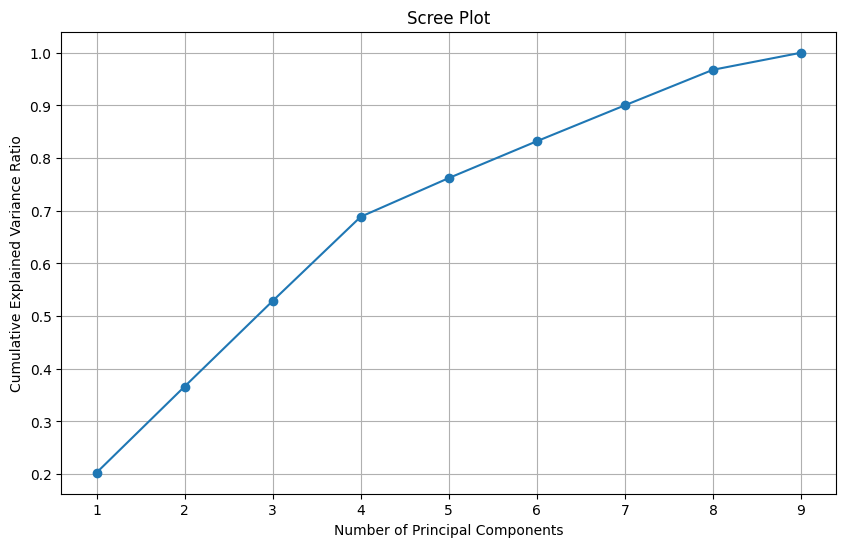

In [38]:
# Calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate the cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Plot the scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid()
plt.show()





**8 out of 9 principal components (PCs) capture approximately 98% of the variance of the data. Therefore, I will select 8 PCs for further analysis.**


In [47]:
pca = PCA(n_components=8)  
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_train_pca.shape, X_test_pca.shape


((70000, 8), (30000, 8))

In [50]:
# Define a dictionary of algorithms with their names and hyperparameters
algorithms = {
    'LogisticRegression': LogisticRegression(n_jobs=-1, random_state=20),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=20),
    'KNeighborsClassifier': KNeighborsClassifier(n_jobs=-1),
    'AdaBoostClassifier': AdaBoostClassifier(random_state=20),
    'RandomForestClassifier': RandomForestClassifier(n_jobs=-1, random_state=20),
    'XGBClassifier': XGBClassifier(n_jobs=-1, random_state=20),
}

results = []

# Iterate through algorithms and train/evaluate models
for algorithm_name, algorithm in algorithms.items():
    result = train_and_evaluate_model(algorithm, X_train_pca, y_train, X_test_pca, y_test)
    results.append(result)

# Create DataFrames for training and test results
df_train_test_pca = pd.DataFrame(results)

# Display the training and test results
print("Training and Test Results:")
print(df_train_test_pca)

Training and Test Results:
                Algorithm  Accuracy (Train)  Precision (Train)  \
0      LogisticRegression          0.503457           0.503173   
1  DecisionTreeClassifier          1.000000           1.000000   
2    KNeighborsClassifier          0.688214           0.688213   
3      AdaBoostClassifier          0.517514           0.517468   
4  RandomForestClassifier          1.000000           1.000000   
5           XGBClassifier          0.684657           0.684731   

   Recall (Train)  F1-score (Train)  Accuracy (Test)  Precision (Test)  \
0        0.503457          0.493289         0.501733          0.501047   
1        1.000000          1.000000         0.495933          0.495984   
2        0.688214          0.688209         0.500567          0.500563   
3        0.517514          0.516930         0.499200          0.498997   
4        1.000000          1.000000         0.500133          0.500060   
5        0.684657          0.684599         0.503567          0.50

In [49]:
df_train

,Algorithm,Accuracy,Precision,Recall,F1-score,Building Time (s)
0,LogisticRegression,0.503457,0.502153,0.361298,0.420236,1.176233
1,DecisionTreeClassifier,1.000000,1.000000,1.000000,1.000000,5.186875
2,KNeighborsClassifier,0.688214,0.688035,0.684306,0.686165,1.969668
3,AdaBoostClassifier,0.517514,0.516768,0.482619,0.499110,8.292743
4,RandomForestClassifier,1.000000,1.000000,1.000000,1.000000,10.474436
5,XGBClassifier,0.684657,0.687875,0.671657,0.679669,0.366546


- The DecisionTreeClassifier and RandomForestClassifier are still overfitting.

- There is not much change even after dimension reduction so we will go with 9 features and use xgboostclassifer as it was best performing

## Final Model : XGBoost Classifier

In [59]:
xgb_classifier = XGBClassifier(
    objective='binary:logistic',  # For binary classification
    random_state=20              # Random seed for reproducibility
)

# Train (fit) the model
xgb_classifier.fit(X_train, y_train)


y_train_pred = xgb_classifier.predict(X_train)
y_test_pred = xgb_classifier.predict(X_test)

# Calculate metrics for train set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

# Calculate metrics for test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Create a DataFrame to store the results
results = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Train': [train_accuracy, train_precision, train_recall, train_f1],
    'Test': [test_accuracy, test_precision, test_recall, test_f1]
})

results



,Metric,Train,Test
0,Accuracy,0.669857,0.505467
1,Precision,0.672913,0.502663
2,Recall,0.656083,0.487226
3,F1-Score,0.664392,0.494824


**we saw its performance without hyperparameter tunning so I would like to do hyperparameter tunning using Optuna**

#### Hyperparameter Tunning (Optuna )

In [58]:
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'booster': 'gbtree',
        'verbosity': 0,
        'n_jobs': -1,
        'random_state': 20,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 40),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
    }

    # Create an XGBoost classifier with the suggested hyperparameters
    model = XGBClassifier(**params)

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate negative recall as the metric to optimize (maximize recall)
    recall = recall_score(y_test, y_pred)
    negative_recall = -recall  # Negative value to maximize recall

    return negative_recall

# Create an Optuna study
study = optuna.create_study(direction='minimize')

# Run the optimization for a specified number of trials
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params
best_learning_rate = best_params['learning_rate']
best_max_depth = best_params['max_depth']
best_n_estimators = best_params['n_estimators']

# Train the final XGBoost model using the best hyperparameters
final_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    booster='gbtree',
    verbosity=0,
    n_jobs=-1,
    random_state=20,
    learning_rate=best_learning_rate,
    max_depth=best_max_depth,
    n_estimators=best_n_estimators
)

final_model.fit(X_train, y_train)

# Evaluate the final model on the test data
y_pred_final = final_model.predict(X_test)
final_recall = recall_score(y_test, y_pred_final)

print("Best Hyperparameters:")
print(f"Learning Rate: {best_learning_rate}")
print(f"Max Depth: {best_max_depth}")
print(f"Number of Estimators: {best_n_estimators}")
print(f"Final Test Recall: {final_recall:.4f}")

[I 2023-09-28 11:18:53,628] A new study created in memory with name: no-name-83070685-ce87-4f97-9762-1b9dac73423a
[I 2023-09-28 11:19:07,840] Trial 0 finished with value: -0.4968819151076242 and parameters: {'learning_rate': 0.29088904977135543, 'max_depth': 21, 'n_estimators': 700}. Best is trial 0 with value: -0.4968819151076242.
[I 2023-09-28 11:19:10,104] Trial 1 finished with value: -0.48823174411587206 and parameters: {'learning_rate': 0.2454997288743533, 'max_depth': 14, 'n_estimators': 100}. Best is trial 0 with value: -0.4968819151076242.
[I 2023-09-28 11:19:12,891] Trial 2 finished with value: -0.49145041239187287 and parameters: {'learning_rate': 0.07891199978752313, 'max_depth': 15, 'n_estimators': 100}. Best is trial 0 with value: -0.4968819151076242.
[I 2023-09-28 11:19:29,817] Trial 3 finished with value: -0.496077248038624 and parameters: {'learning_rate': 0.23657125871780468, 'max_depth': 34, 'n_estimators': 700}. Best is trial 0 with value: -0.4968819151076242.
[I 202

Best Hyperparameters:
Learning Rate: 0.29148082426954464
Max Depth: 25
Number of Estimators: 100
Final Test Recall: 0.5026




**After hyperparameter tuning, the performance of the model did not improve. Hence, I choose XGBoost CLassifier without hyperparameter tunning and perform cross-validation on it.**

In [60]:


#creating a dataframe of probabilities, actual labels, predicted labels for general check

probabilities = xgb_classifier.predict_proba(X_train)

predicted_labels = xgb_classifier.predict(X_train)

results = pd.DataFrame({'Probability': probabilities[:, 1],
                        'Actual_Label': y_train,
                        'Predicted_Label': predicted_labels})

results.sample(10)



,Probability,Actual_Label,Predicted_Label
4027,0.591723,0,1
67498,0.535739,0,1
61407,0.459940,1,0
34570,0.552889,1,1
35783,0.537937,0,1
5774,0.413053,0,0
24476,0.530018,1,1
21536,0.484019,0,0
62090,0.458124,1,0
40771,0.629054,1,1


In [61]:
#check evaulation metrics for different thresholds

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Creating an empty DataFrame to store the evaluation metrics
metrics_df = pd.DataFrame(columns=['Probability', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Iterating over the probability thresholds
for threshold in thresholds:
    # Converting probabilities to predicted labels based on the threshold
    predicted_labels = (probabilities[:, 1] >= threshold).astype(int)

    # Calculating evaluation metrics
    accuracy = accuracy_score(y_train, predicted_labels)
    precision = precision_score(y_train, predicted_labels, zero_division=1)
    recall = recall_score(y_train, predicted_labels, zero_division=1)
    f1 = f1_score(y_train, predicted_labels, zero_division=1)

    # Adding the metrics to the DataFrame
    metrics_df = pd.concat([metrics_df, pd.DataFrame({'Probability': [threshold],
                                                      'Accuracy': [accuracy],
                                                      'Precision': [precision],
                                                      'Recall': [recall],
                                                      'F1 Score': [f1]})], ignore_index=True)
metrics_df

,Probability,Accuracy,Precision,Recall,F1 Score
0,0.1,0.498300,0.498192,1.000000,0.665058
1,0.2,0.501057,0.499570,0.999943,0.666272
2,0.3,0.518586,0.508517,0.999168,0.674006
3,0.4,0.581514,0.544772,0.972265,0.698286
4,0.5,0.669857,0.672913,0.656083,0.664392
5,0.6,0.582643,0.875681,0.188895,0.310756
6,0.7,0.521029,0.973126,0.039465,0.075854
7,0.8,0.504429,1.000000,0.005048,0.010045
8,0.9,0.502000,1.000000,0.000172,0.000344
9,1.0,0.501914,1.000000,0.000000,0.000000


### Trade off between Accuracy, Sensitivity, Specitivity, F-1 Score and Probabilities (Thresholds)

Best Threshold: 0.44
Best F1 Score: 0.7088


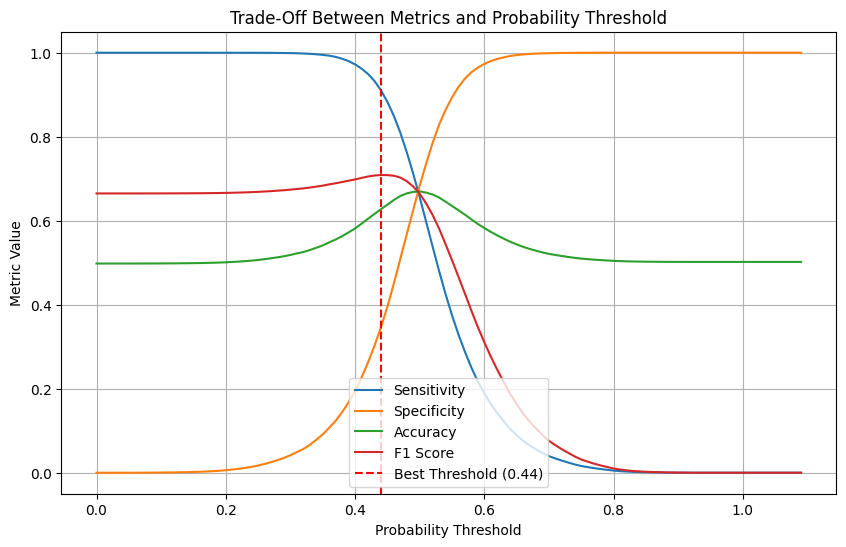

In [66]:
# Calculate predicted probabilities for the train data
train_probabilities = xgb_classifier.predict_proba(X_train)[:, 1]

# Apply different thresholds to obtain binary predictions for train data
thresholds = np.arange(0, 1.1, 0.01)

# Initialize lists to store metric values
sensitivity = []
specificity = []
accuracy = []
f1_scores = []

for threshold in thresholds:
    train_predictions = (train_probabilities >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_train, train_predictions).ravel()
    
    # Calculate metrics
    sensitivity.append(tp / (tp + fn))
    specificity.append(tn / (tn + fp))
    accuracy.append((tp + tn) / (tp + tn + fp + fn))
    f1_scores.append(f1_score(y_train, train_predictions))

# Find the threshold that maximizes F1 Score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1_score = max(f1_scores)

# Plot the trade-off curves
plt.figure(figsize=(10, 6))
plt.plot(thresholds, sensitivity, label='Sensitivity')
plt.plot(thresholds, specificity, label='Specificity')
plt.plot(thresholds, accuracy, label='Accuracy')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best Threshold ({best_threshold:.2f})')
plt.xlabel('Probability Threshold')
plt.ylabel('Metric Value')
plt.title('Trade-Off Between Metrics and Probability Threshold')
plt.legend()
plt.grid(True)

# Print the best threshold and F1 Score
print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1 Score: {best_f1_score:.4f}")

# Show the plot
plt.show()

**Best threshold we got is 0.44**

### AUC ROC Curve
- The ROC curve plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold values.
-  the Area Under the ROC Curve (AUC-ROC) score to quantify the overall performance of the model.
- You can find the optimal threshold by maximizing the Youden's J statistic, which is defined as (Sensitivity + Specificity - 1). The threshold that corresponds to the maximum J statistic is considered optimal.

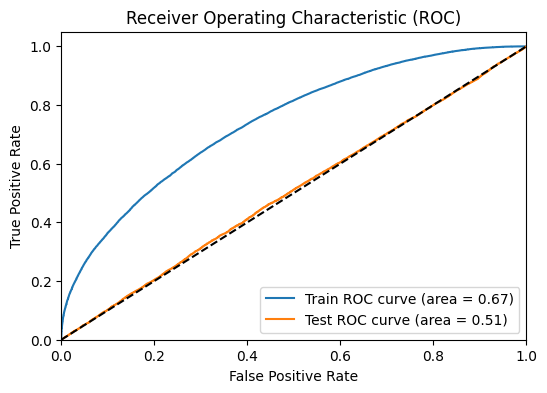

Best Threshold: 0.5002318


In [69]:
# Calculate predicted probabilities for the train data
train_probabilities = xgb_classifier.predict_proba(X_train)[:, 1]

# Calculate the ROC curve and AUC for train data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, train_probabilities)
roc_auc_train = auc(fpr_train, tpr_train)

# Calculate the ROC curve and AUC for test data
test_probabilities = xgb_classifier.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, test_probabilities)
roc_auc_test = auc(fpr_test, tpr_test)

# Find the best threshold that maximizes Youden's J statistic
J = tpr_train - fpr_train
best_threshold_index = np.argmax(J)
best_threshold = thresholds_train[best_threshold_index]

# Apply the best threshold to obtain binary predictions for train and test data
train_predictions = (train_probabilities >= best_threshold).astype(int)
test_predictions = (test_probabilities >= best_threshold).astype(int)

# Calculate the ROC-AUC score for train and test data using the best threshold
roc_auc_train_best = roc_auc_score(y_train, train_predictions)
roc_auc_test_best = roc_auc_score(y_test, test_predictions)

# Plot the ROC curves
plt.figure(figsize=(6, 4))
plt.plot(fpr_train, tpr_train, label='Train ROC curve (area = {:.2f})'.format(roc_auc_train_best))
plt.plot(fpr_test, tpr_test, label='Test ROC curve (area = {:.2f})'.format(roc_auc_test_best))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Print the best threshold
print("Best Threshold:", best_threshold)

- We calculate the ROC curve and AUC for both the training and test data using the roc_curve and auc functions.
- We find the best threshold that maximizes Youden's J statistic (tpr_train - fpr_train) and apply it to obtain binary predictions for both train and test data.
- We calculate the ROC-AUC score for train and test data using the best threshold and plot the ROC curves with the updated AUC values.